## Machine learning

### Config and def

In [24]:
import sys, os, math, time, datetime
import warnings
import numpy as np
from numpy.random import *
import pandas as pd
import itertools

from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from sklearn.preprocessing import scale
from scipy.spatial import distance as kld_dist

import matplotlib.pyplot as plt

##### directories #####
add_eeg_dir = f'../../../datasets/2306/2306_elan/preprocessing/11_add_Transcrip_to_IM' 
subject_ID_csv_list = sorted(os.listdir(f'{add_eeg_dir}'))
subject_ID_list = [i.removesuffix('.csv') for i in subject_ID_csv_list]

##### prep df and label #####
all_df = pd.DataFrame()
for subject_ID_csv in subject_ID_csv_list:
    subject_ID = subject_ID_csv[:-4]
    each_subject_df = pd.read_table(f'{add_eeg_dir}/{subject_ID_csv}', sep='\t', header=0)
    all_df = pd.concat([all_df, each_subject_df], axis=0).reset_index(drop=True)

SS_score_df = all_df['self-reported sentiment']
SS_ternary_ar = np.where(SS_score_df >= 5, 2, np.where(SS_score_df <= 3, 0, 1))
all_df.insert(loc=8, column= 'SS_ternary', value= SS_ternary_ar)

TS_score_df = all_df.loc[:, 'UI_F1':'UI_M1'].mean(axis=1)
TS_ternary_ar = np.where(TS_score_df >= 4.5, 2, np.where(TS_score_df <= 3.5, 0, 1))
all_df.insert(loc=10, column= 'TS_ternary', value= TS_ternary_ar)
all_df.insert(loc=11, column= 'third-party sentiment', value= TS_score_df)

all_subject_df = all_df.copy()

##### config #####
## TimeSeriesSplit
info_dict_tss = {
                'n_splits': 3,
                'max_train_size': 36,
                'valid_test_ratio': 2,
                'feat_percentile_list': None, # None, np.arange(12.5, 100, 12.5),
                'bin_sect_thres_list': [1], # [1], None, ### power_of_bin < valid_value
                'bin_sect_thres_v2_list': [1], # [1], None, ### power_of_bin > valid_value
                'valid_target': 'bin_sect_thres', # 'NONE', 'random', 'corr', 'feat_percentile', 'bin_sect_thres', 'bin_sect_thres_v2'
                'best_valid_value': None,
                'open_close_config': 'open', # None, 'open', 'close', 'both'
                'feat_sect': False  # True or False
                }

## configs == LREC2024
info_dict_svm = {
                'C': [0.001, 0.01, 0.1, 1, 10, 100],
                'epsilon': [0, 0.5, 1],
                'kernel': 'linear',
                'scoring': 'neg_mean_absolute_error',
                }

rep_exp = 1*info_dict_tss['n_splits']
                 
### modalities and combination ###
validation_method = 'Time_Series_Split'

feat_collections_df = pd.DataFrame(
                data=[{'modal_name': 'BAU',   'sf_name': 'BAU_000',               'ef_name': 'BAU_767'},
                      {'modal_name': 'A',     'sf_name': 'pcm_RMSenergy_sma_max', 'ef_name': 'F0_sma_de_kurtosis'},
                      {'modal_name': 'V',     'sf_name': '17_acceleration_max',   'ef_name': 'AU45_c_mean'},
                      {'modal_name': 'P',     'sf_name': 'EDA_mean',              'ef_name': 'EDA_gsr'},
                      {'modal_name': 'IM',    'sf_name': 'IM_00',                 'ef_name': 'IM_44'},
                      ],
                       index=None)
T_modal_name = 'BAU'
A_modal_name = 'A'
V_modal_name = 'V'
P_modal_name = 'P'
B_modal_name = 'IM'

modality_list = [T_modal_name, A_modal_name, V_modal_name, P_modal_name, B_modal_name]
#modality_list = [T_modal_name, A_modal_name, B_modal_name]

combination_list = []
for n in range(1,len(modality_list)+1):
	for comb in itertools.combinations(modality_list, n):
	    combination_list.append(list(comb))

dep_list = ['dependent']
dummy = '../ML_results/dummy'
task_list = ['reg']
eval_list = [['MAE', 'R2', 'Rp', 'Rs']]
label_name_list = ['self-reported sentiment'] #['SS_ternary']
ml_model_name_list = ['SVM']
combination_list = [[B_modal_name]]  # [['BAU'], ['A'], ['V'], ['P'], [B_modal_name]]

print(combination_list)

##### functions #####
def own_prediction_reg(X_train, X_valid, X_test, y_train, y_valid, y_test, ml_mod, info_dict):
        
    if ml_mod == 'SVM':
        
        kernel = info_dict['kernel']
        C_list = info_dict['C']
        epsilon_list = info_dict['epsilon']
        scoring = info_dict['scoring']

        valid_mae = None
        best_valid_mae = 9999
        valid_best_C = None
        valid_best_epsilon = None
        for C in C_list:
            for epsilon in epsilon_list:
                regr = SVR(kernel=kernel, C=C, epsilon=epsilon, max_iter=1000)
                regr.fit(X_train, y_train)
                y_valid_pred = regr.predict(X_valid)
                y_valid_pred = np.where(y_valid_pred < 1, 1, y_valid_pred) # 外れ値の補正
                y_valid_pred = np.where(y_valid_pred > 7, 7, y_valid_pred) # 外れ値の補正
                
                if scoring == 'neg_mean_absolute_error':
                    valid_mae = mean_absolute_error(y_valid_pred, y_valid)
                else:
                    print('set the scoring')
                    sys.exit()
                    
                if valid_mae < best_valid_mae:
                    best_valid_mae = valid_mae
                    valid_best_C = C
                    valid_best_epsilon = epsilon
                    
        best_model = SVR(kernel=kernel, C=valid_best_C, epsilon=valid_best_epsilon, max_iter=1000)
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        y_pred = np.where(y_pred < 1, 1, y_pred) # 外れ値の補正
        y_pred = np.where(y_pred > 7, 7, y_pred) # 外れ値の補正
        
    return y_pred, y_test   

def Time_Series_prediction_reg(all_subject_df, feat_collections_df, modal_comb, subject_ID, label_name, rep_exp_num, fusion_method, ml_mod, info_dict):
       
    train_test_QUE = 'subject_ID == ' + '\"' + subject_ID + '\"'
    exchange_ID_list = all_subject_df.query(train_test_QUE)['exchange_ID'].values
    
    n_splits = info_dict['n_splits']
    max_train_size = info_dict['max_train_size']
    tss_a = TimeSeriesSplit(n_splits=n_splits, max_train_size=max_train_size)
    
    if n_splits == 3:
        series_count = 0
        for train_ex, val_tes_ex in tss_a.split(exchange_ID_list):
            series_count += 1
            if rep_exp_num in [1, 4, 7] and series_count == 1:
                train_list = list(exchange_ID_list[train_ex])
                val_tes_list = list(exchange_ID_list[val_tes_ex])
            elif rep_exp_num in [2, 5, 8] and series_count == 2:
                train_list = list(exchange_ID_list[train_ex])
                val_tes_list = list(exchange_ID_list[val_tes_ex])
            elif rep_exp_num in [3, 6, 9] and series_count == 3:
                train_list = list(exchange_ID_list[train_ex])
                val_tes_list = list(exchange_ID_list[val_tes_ex])
            else:
                pass
                       
    train_all_df = all_subject_df.query(train_test_QUE).query('exchange_ID == @train_list')
    val_tes_all_df = all_subject_df.query(train_test_QUE).query('exchange_ID == @val_tes_list')

    valid_length = len(val_tes_all_df) // info_dict['valid_test_ratio']
 
    valid_all_df = val_tes_all_df.iloc[:valid_length, :]
    test_all_df = val_tes_all_df.iloc[valid_length:, :]
    
    tmp_X_train_tn = []
    tmp_X_valid_tn = []
    tmp_X_test_tn = []
    for modal_name in modal_comb:
        
        sf_name = feat_collections_df.query('modal_name == @modal_name')['sf_name'].iloc[-1]
        ef_name = feat_collections_df.query('modal_name == @modal_name')['ef_name'].iloc[-1]
        
        X_train_ar = train_all_df.loc[:, sf_name:ef_name].reset_index(drop=True).values
        X_valid_ar = valid_all_df.loc[:, sf_name:ef_name].reset_index(drop=True).values
        X_test_ar = test_all_df.loc[:, sf_name:ef_name].reset_index(drop=True).values
        y_train = train_all_df.loc[:, label_name].reset_index(drop=True).values
        y_valid = valid_all_df.loc[:, label_name].reset_index(drop=True).values
        y_test = test_all_df.loc[:, label_name].reset_index(drop=True).values
        
        if (info_dict['valid_target'] != 'NONE') and modal_name  == 'IM': #modal_comb[0]  == 'IM':
            
            print('IM_custimized')
            
            if info_dict['valid_target'] in ['feat_percentile', 'bin_sect_thres', 'bin_sect_thres_v2']:
                
                all_open_close_pxx_df = pd.read_csv(f'../../project-ACII2024/rest_and_btw_log/1701767293/resting_session/all_open_close_pxx_df.csv', header=0)
                all_recall_pxx_df = pd.read_csv(f'../../project-ACII2024/rest_and_btw_log/1703138526/recall_session/all_recall_pxx_df.csv', header=0)
                
                all_open_close_pxx_df_2306M2002 = pd.read_csv(f'../../project-ACII2024/rest_and_btw_log/1706949098/resting_session/all_open_close_pxx_df_2306M2002.csv', header=0)
                all_open_close_pxx_df = pd.concat([all_open_close_pxx_df,all_open_close_pxx_df_2306M2002], axis=0).reset_index(drop=True)
                
                tmp_QUE = 'subject_ID == ' + '\"' + subject_ID + '\"'
                
                if info_dict['open_close_config'] == 'both':
                    
                    subject_open_close_df = all_open_close_pxx_df.query(tmp_QUE).loc[:, '2':'46'].reset_index(drop=True)
                    subject_open_close_df = subject_open_close_df.div(subject_open_close_df.sum(axis=1), axis=0)
                    
                elif info_dict['open_close_config'] == 'open':
                    
                    subject_open_df = all_open_close_pxx_df[all_open_close_pxx_df["ex_ID"].str.contains("open")]           
                    subject_open_df = subject_open_df.query(tmp_QUE).loc[:, '2':'46'].reset_index(drop=True)
                    subject_open_close_df = subject_open_df.div(subject_open_df.sum(axis=1), axis=0)
                    
                elif info_dict['open_close_config'] == 'close':
                    
                    subject_close_df = all_open_close_pxx_df[all_open_close_pxx_df["ex_ID"].str.contains("close")]
                    subject_close_df = subject_close_df.query(tmp_QUE).loc[:, '2':'46'].reset_index(drop=True)
                    subject_open_close_df = subject_close_df.div(subject_close_df.sum(axis=1), axis=0)
                    
                elif info_dict['open_close_config'] is None:
                    
                    pass
                
                else:
                    print('open_close_config error')
                    sys.exit()
                        
                subject_recall_df = all_recall_pxx_df.query(tmp_QUE).loc[:, '2':'46'].reset_index(drop=True)
            
            valid_target = info_dict['valid_target']
            #if (subject_ID != '2306M2002') or (subject_ID == '2306M2002' and valid_target not in ['feat_percentile', 'bin_sect_thres']):
                
            best_valid_value = None
            valid_mae = None
            best_valid_mae = 9999
            
            if valid_target in ['random', 'corr', 'feat_percentile']:
                valid_list = info_dict['feat_percentile_list']
            elif valid_target == 'bin_sect_thres' or valid_target == 'bin_sect_thres_v2':
                valid_list = info_dict[f'{valid_target}_list']
            else:
                print('valid_target error')
                sys.exit()
                
            for valid_value in valid_list:
                
                tmp_tmp_X_train_tn = []
                tmp_tmp_X_valid_tn = []
                tmp_tmp_X_test_tn = []
                
                tmp_X_train_ar = X_train_ar.copy()
                tmp_X_valid_ar = X_valid_ar.copy()
                tmp_X_test_ar = X_test_ar.copy()
                
                if valid_target in ['feat_percentile', 'bin_sect_thres', 'bin_sect_thres_v2']:
                    tmp_X_train_ar, tmp_X_valid_ar, tmp_X_test_ar = norm_based_correction(tmp_X_train_ar, tmp_X_valid_ar, tmp_X_test_ar,
                                                                                        subject_open_close_df, subject_recall_df,
                                                                                        valid_value, info_dict) # valid
                elif valid_target in ['corr', 'random']:
                    tmp_X_train_ar, tmp_X_valid_ar, tmp_X_test_ar = feat_sect_corr(tmp_X_train_ar, tmp_X_valid_ar, tmp_X_test_ar, y_train,
                                                                                    valid_value, False, info_dict) # valid
                else:
                    print('valid_target error')
                    sys.exit()
                
                mean_tmp = np.nanmean(tmp_X_train_ar, axis=0).copy()
                std_tmp = np.nanstd(tmp_X_train_ar, axis=0, ddof=1).copy()
                tmp_X_train_ar = (tmp_X_train_ar - mean_tmp) / std_tmp
                tmp_X_valid_ar = (tmp_X_valid_ar - mean_tmp) / std_tmp
                tmp_X_test_ar = (tmp_X_test_ar - mean_tmp) / std_tmp
                    
                pd.DataFrame(tmp_X_train_ar)[pd.DataFrame(tmp_X_train_ar).abs() > 1e+100] = 0 # substitution for bug based on openSMILE F0_sma_min = 0 in all samples
                pd.DataFrame(tmp_X_valid_ar)[pd.DataFrame(tmp_X_valid_ar).abs() > 1e+100] = 0 
                pd.DataFrame(tmp_X_test_ar)[pd.DataFrame(tmp_X_test_ar).abs() > 1e+100] = 0
                
                tmp_tmp_X_train_tn.append(np.nan_to_num(tmp_X_train_ar, nan=0)) # openSMILE F0_sma_min = 0 in all samples
                tmp_tmp_X_valid_tn.append(np.nan_to_num(tmp_X_valid_ar, nan=0))
                tmp_tmp_X_test_tn.append(np.nan_to_num(tmp_X_test_ar, nan=0))
                
                X_train = tmp_tmp_X_train_tn[0]; X_valid = tmp_tmp_X_valid_tn[0]; X_test = tmp_tmp_X_test_tn[0]
                                                                                
                kernel = info_dict['kernel']
                C_list = info_dict['C']
                epsilon_list = info_dict['epsilon']
                scoring = info_dict['scoring']

                for C in C_list:
                    for epsilon in epsilon_list:
                        regr = SVR(kernel=kernel, C=C, epsilon=epsilon, max_iter=1000)
                        regr.fit(X_train, y_train)
                        y_valid_pred = regr.predict(X_valid)
                        y_valid_pred = np.where(y_valid_pred < 1, 1, y_valid_pred) # 外れ値の補正
                        y_valid_pred = np.where(y_valid_pred > 7, 7, y_valid_pred) # 外れ値の補正
                        
                        if scoring == 'neg_mean_absolute_error':
                            valid_mae = mean_absolute_error(y_valid_pred, y_valid)
                        else:
                            print('set the scoring')
                            sys.exit()
                            
                        if valid_mae < best_valid_mae:
                            best_valid_mae = valid_mae
                            best_valid_value = valid_value
            
            print(f'best_{valid_target}={best_valid_value}')
            info_dict[f'best_{valid_target}'] = best_valid_value
            if valid_target in ['feat_percentile', 'bin_sect_thres', 'bin_sect_thres_v2']:        
                X_train_ar, X_valid_ar, X_test_ar = norm_based_correction(X_train_ar, X_valid_ar, X_test_ar,
                                                                        subject_open_close_df, subject_recall_df,
                                                                        best_valid_value, info_dict) # decided valid_value
            elif valid_target in ['corr', 'random']:
                X_train_ar, X_valid_ar, X_test_ar = feat_sect_corr(X_train_ar, X_valid_ar, X_test_ar, y_train,
                                                                    best_valid_value, True, info_dict) # decided feat_percentile
                
            else:
                print('valid_target error')
                sys.exit()
            
        else:
            print('IM with \'NONE\' or other modality')
            pass
        
        
        if modal_name in ['BAU']:
            pass
        elif modal_name in ['A', 'V', 'P', 'IM']:
            mean_tmp = np.nanmean(X_train_ar, axis=0).copy()
            std_tmp = np.nanstd(X_train_ar, axis=0, ddof=1).copy()
            X_train_ar = (X_train_ar - mean_tmp) / std_tmp
            X_valid_ar = (X_valid_ar - mean_tmp) / std_tmp
            X_test_ar = (X_test_ar - mean_tmp) / std_tmp
        else:
            print(f'{modal_name} does not Normalize.')
            sys.exit()
            
        pd.DataFrame(X_train_ar)[pd.DataFrame(X_train_ar).abs() > 1e+100] = 0 # substitution for bug based on openSMILE F0_sma_min = 0 in all samples
        pd.DataFrame(X_valid_ar)[pd.DataFrame(X_valid_ar).abs() > 1e+100] = 0 
        pd.DataFrame(X_test_ar)[pd.DataFrame(X_test_ar).abs() > 1e+100] = 0
        
        tmp_X_train_tn.append(np.nan_to_num(X_train_ar, nan=0)) # openSMILE F0_sma_min = 0 in all samples
        tmp_X_valid_tn.append(np.nan_to_num(X_valid_ar, nan=0)) 
        tmp_X_test_tn.append(np.nan_to_num(X_test_ar, nan=0))
        
    if fusion_method == 'uni':
        
        X_train = tmp_X_train_tn[0]; X_valid = tmp_X_valid_tn[0]; X_test = tmp_X_test_tn[0]
        
    elif fusion_method == 'EF':
        
        if len(tmp_X_train_tn) == 1:
            print('preparation_error')
            sys.exit()
        
        if not info_dict['feat_sect']:
        
            valid_dummy = tmp_X_test_tn.copy()
            
            X_train, X_test = early_fusion(tmp_X_train_tn, tmp_X_test_tn, modal_comb)
            X_valid, _ = early_fusion(tmp_X_valid_tn, valid_dummy, modal_comb)
            
        elif info_dict['feat_sect']:
            
            X_train, X_valid, X_test = modality_selection(tmp_X_train_tn, tmp_X_valid_tn, tmp_X_test_tn, y_train, y_valid, info_dict)
                      
        else:
            print('feat_sect_error')
            sys.exit()

    else:
        print('fusion_method_error')
        sys.exit()
    
    print('X_train shape', np.shape(X_train), 'y_train shape', np.shape(y_train),
          'X_valid shape', np.shape(X_valid), 'y_valid shape', np.shape(y_valid),
          'X_test shape', np.shape(X_test), 'y_test shape', np.shape(y_test))
    info_dict['used_bin_num'] = np.shape(X_train)[1]
        
    if ml_mod == 'SVM':
        
        majority_mae = mean_absolute_error(np.ones(len(y_test))*np.mean(y_train), y_test)        
        y_pred, y_test = own_prediction_reg(X_train, X_valid, X_test, y_train, y_valid, y_test, ml_mod, info_dict)
        
    else:
        print('learning model')
        sys.exit()
    
    return y_pred, y_test, majority_mae


def modality_selection(tmp_X_train_tn, tmp_X_valid_tn, tmp_X_test_tn, y_train, y_valid, info_dict):
    
    modal_valid_comb = info_dict['modal_comb']
    
    modal_combination_list = []
    for n in range(1,len(modal_valid_comb)+1):
        for comb in itertools.combinations(modal_valid_comb, n):
            modal_combination_list.append(list(comb))
            
    comb_len_list = [len(s) for s in modal_combination_list]
    comb_index_list = np.arange(0, len(modal_combination_list), 1)
    
    bimodal_selection_counter = -1
    trimodal_selection_counter = -1
    valid_mae = None
    best_valid_mae = 9999
    best_comb_index = None
    for modal_valid_comb, comb_len, comb_index in zip(modal_combination_list, comb_len_list, comb_index_list):
                
        if comb_len == 1:
        
            X_train = tmp_X_train_tn[comb_index]
            X_valid = tmp_X_valid_tn[comb_index]
            X_test = tmp_X_test_tn[comb_index]
        
        elif comb_len == 2:
            
            continue
                        
            # if bimodal_selection_counter == -1:
         
            #     X_train = np.concatenate([tmp_X_train_tn[0], tmp_X_train_tn[1]], 1)
            #     X_valid = np.concatenate([tmp_X_valid_tn[0], tmp_X_valid_tn[1]], 1)
            #     X_test = np.concatenate([tmp_X_test_tn[0], tmp_X_test_tn[1]], 1)
                
            #     bimodal_selection_counter = 1
                
            # elif bimodal_selection_counter == 1:
                
            #     X_train = np.concatenate([tmp_X_train_tn[0], tmp_X_train_tn[2]], 1)
            #     X_valid = np.concatenate([tmp_X_valid_tn[0], tmp_X_valid_tn[2]], 1)
            #     X_test = np.concatenate([tmp_X_test_tn[0], tmp_X_test_tn[2]], 1)
                
            #     bimodal_selection_counter = 2
                
            # elif bimodal_selection_counter == 2:
                
            #     X_train = np.concatenate([tmp_X_train_tn[1], tmp_X_train_tn[2]], 1)
            #     X_valid = np.concatenate([tmp_X_valid_tn[1], tmp_X_valid_tn[2]], 1)
            #     X_test = np.concatenate([tmp_X_test_tn[1], tmp_X_test_tn[2]], 1)
                
            #     bimodal_selection_counter = 3
                
            # else:
            #     print('bimodal combination error')
            #     sys.exit()
                
        elif comb_len == 3:
            
            continue
            
            # if trimodal_selection_counter == -1:
         
            #     X_train = np.concatenate([tmp_X_train_tn[0], tmp_X_train_tn[1], tmp_X_train_tn[2]], 1)
            #     X_valid = np.concatenate([tmp_X_valid_tn[0], tmp_X_valid_tn[1], tmp_X_valid_tn[2]], 1)
            #     X_test = np.concatenate([tmp_X_test_tn[0], tmp_X_test_tn[1], tmp_X_test_tn[2]], 1)
                
            #     trimodal_selection_counter = 1
                
            # else:
            #     print('trimodal combination error')
            #     sys.exit()
                
    
        kernel = info_dict['kernel']
        C_list = info_dict['C']
        epsilon_list = info_dict['epsilon']
        scoring = info_dict['scoring']

        for C in C_list:
            for epsilon in epsilon_list:
                regr = SVR(kernel=kernel, C=C, epsilon=epsilon, max_iter=1000)
                regr.fit(X_train, y_train)
                y_valid_pred = regr.predict(X_valid)
                y_valid_pred = np.where(y_valid_pred < 1, 1, y_valid_pred) # 外れ値の補正
                y_valid_pred = np.where(y_valid_pred > 7, 7, y_valid_pred) # 外れ値の補正
                
                if scoring == 'neg_mean_absolute_error':
                    valid_mae = mean_absolute_error(y_valid_pred, y_valid)
                else:
                    print('set the scoring')
                    sys.exit()
                    
                if valid_mae < best_valid_mae:
                    best_valid_mae = valid_mae
                    best_comb_index = comb_index
                    
    best_comb = modal_combination_list[best_comb_index]
                    
    print(f'{len(best_comb)} modality is selected. best_comb = {best_comb}.')
    
    if len(best_comb) == 1:
        
        info_dict['best_selected_modal'] = best_comb
    
        X_train = tmp_X_train_tn[best_comb_index]
        X_valid = tmp_X_valid_tn[best_comb_index]
        X_test = tmp_X_test_tn[best_comb_index]
    
    elif len(best_comb) == 2:
        
        print('method is abortd')
        sys.exit()
        
        # modal_index_1 = modal_combination_list.index([best_comb[0]])
        # modal_index_2 = modal_combination_list.index([best_comb[1]])
        
        # X_train = np.concatenate([tmp_X_train_tn[modal_index_1], tmp_X_train_tn[modal_index_2]], 1)
        # X_valid = np.concatenate([tmp_X_valid_tn[modal_index_1], tmp_X_valid_tn[modal_index_2]], 1)
        # X_test = np.concatenate([tmp_X_test_tn[modal_index_1], tmp_X_test_tn[modal_index_2]], 1)
                       
    elif len(best_comb) == 3:
        
        print('method is abortd')
        sys.exit()
              
        # X_train = np.concatenate([tmp_X_train_tn[0], tmp_X_train_tn[1], tmp_X_train_tn[2]], 1)
        # X_valid = np.concatenate([tmp_X_valid_tn[0], tmp_X_valid_tn[1], tmp_X_valid_tn[2]], 1)
        # X_test = np.concatenate([tmp_X_test_tn[0], tmp_X_test_tn[1], tmp_X_test_tn[2]], 1)
        
    else:
        print('best_comb_len error')
        sys.exit()
            
    return X_train, X_valid, X_test
    

def norm_based_correction(X_train_ar, X_valid_ar, X_test_ar,
                          subject_open_close_df, subject_recall_df,
                          valid_value, info_dict):

    recall_change_level_each_bin = subject_recall_df.mean(axis=0) / subject_open_close_df.mean(axis=0)
    # max = 4.901 in 2306F4002

    del_column_num_list = []
    j = 0
    for power_of_bin in recall_change_level_each_bin:
        
        if info_dict['valid_target'] == 'feat_percentile':
            if power_of_bin < np.percentile(recall_change_level_each_bin, valid_value):
                del_column_num_list.append(j)
            else:
                pass
        elif info_dict['valid_target'] == 'bin_sect_thres':
            if power_of_bin < valid_value:
                del_column_num_list.append(j)
                if len(del_column_num_list) == np.shape(X_train_ar)[-1]:
                    del_column_num_list = np.delete(np.arange(0,45,1), int(recall_change_level_each_bin.reset_index(drop=True).idxmax()))
            else:
                pass
            
        # elif info_dict['valid_target'] == 'bin_sect_thres_v2':
        #     if power_of_bin > valid_value :
        #         del_column_num_list.append(j)
        #         if len(del_column_num_list) == np.shape(X_train_ar)[-1]:
        #             del_column_num_list = np.delete(np.arange(0,45,1), int(recall_change_level_each_bin.reset_index(drop=True).idxmax()))
        #     else:
        #         pass
        
        elif info_dict['valid_target'] == 'bin_sect_thres_v2':
            
            subject_ID = info_dict['subject_ID']
            pred_del_dim = del_dim_num_list_df.query('subject_ID==@subject_ID')['pred_del_dim'].iloc[-1]
            #del_dim_num = del_dim_num_list_df.query('subject_ID==@subject_ID')['del_dim_num'].iloc[-1]
            
            if sorted(recall_change_level_each_bin, reverse=True).index(power_of_bin) < 45 - pred_del_dim :
                pass
            else:
                del_column_num_list.append(j)
                if len(del_column_num_list) == np.shape(X_train_ar)[-1]:
                    del_column_num_list = np.delete(np.arange(0,45,1), int(recall_change_level_each_bin.reset_index(drop=True).idxmax()))
            
        else:
            pass
        
        j += 1

    correct_X_train_ar = pd.DataFrame(X_train_ar).drop(pd.DataFrame(X_train_ar).columns[del_column_num_list], axis=1).values
    correct_X_valid_ar = pd.DataFrame(X_valid_ar).drop(pd.DataFrame(X_valid_ar).columns[del_column_num_list], axis=1).values
    correct_X_test_ar = pd.DataFrame(X_test_ar).drop(pd.DataFrame(X_test_ar).columns[del_column_num_list], axis=1).values
               
    return correct_X_train_ar, correct_X_valid_ar, correct_X_test_ar

def early_fusion(tmp_X_train_tn, tmp_X_test_tn, modal_comb):
    
    for i in range(len(modal_comb)):
        if i == 0:
            X_train = tmp_X_train_tn[i]
            X_test = tmp_X_test_tn[i]
        else:          
            X_train = np.concatenate([X_train, tmp_X_train_tn[i]], 1)
            X_test = np.concatenate([X_test, tmp_X_test_tn[i]], 1)

    return X_train, X_test

def feat_sect_corr(tmp_X_train_ar, tmp_X_valid_ar, tmp_X_test_ar, y_train, valid_value, decision, info_dict):
    
    if info_dict['valid_target'] == 'corr':
    
        sect_bin_list_df = pd.DataFrame(columns=['bin', 'corr'])
        for one_bin in range(np.shape(tmp_X_train_ar)[1]):
            num_and_corr = pd.DataFrame([[one_bin, spearmanr(tmp_X_train_ar[:, one_bin], y_train)[0]]], columns=['bin', 'corr'])
            
            if spearmanr(tmp_X_train_ar[:, one_bin], y_train)[1] < 0.05:
                sect_bin_list_df = pd.concat([sect_bin_list_df, num_and_corr], axis=0).reset_index(drop=True)

        origin_sect_bin_list_df = sect_bin_list_df.copy()
        sect_bin_list_df = sect_bin_list_df.sort_values('corr', ascending=False)
        sect_feat_range = math.ceil(len(sect_bin_list_df)*valid_value/100)
        sect_bin_list_df = sect_bin_list_df.iloc[:sect_feat_range, :]
        
        if len(sect_bin_list_df[sect_bin_list_df['corr'] > 0]) != 0:
            sect_bin_list_df = sect_bin_list_df[sect_bin_list_df['corr'] > 0]
            sect_feat_bin = np.array(sect_bin_list_df['bin'].values, dtype='int64')
            if decision:
                print('selected_feat_corr', sect_bin_list_df)
        else:
            sect_bin_list_df = origin_sect_bin_list_df  # .sort_values('corr', ascending=False).iloc[:25, :] # sect_bin_list_df.iloc[0, :]
            sect_feat_bin = np.arange(0,45,1)
            if decision:
                print('selected_feat_corr', 'there are no pos corr.')
    
    elif info_dict['valid_target'] == 'random':
        sect_feat_bin = choice(np.arange(0, np.shape(tmp_X_train_ar)[1] ,1), math.ceil(np.shape(tmp_X_train_ar)[1]*valid_value/100), replace = False)
        #sect_feat_bin = np.arange(0,3,1)   ##### delta     frequency corresponded to IM00-IM02 1 < w < 4
        #sect_feat_bin = np.arange(3,6,1)   ##### theta     frequency corresponded to IM03-IM05 4 < w < 7
        #sect_feat_bin = np.arange(7,12,1)   ##### alpha    frequency corresponded to IM07-IM11 8 < w < 13
        #sect_feat_bin = np.arange(12,29,1) ##### beta      frequency corresponded to IM12-IM28 13 < w < 30
        #sect_feat_bin = np.arange(29,45,1) ##### gamma     frequency corresponded to IM29-IM44 30 < w < 45
        
    else:
        print('valid_target error')
        sys.exit()
    
    correct_X_train_ar = tmp_X_train_ar[:, sect_feat_bin]
    correct_X_valid_ar = tmp_X_valid_ar[:, sect_feat_bin]
    correct_X_test_ar = tmp_X_test_ar[:, sect_feat_bin]
    
    return correct_X_train_ar, correct_X_valid_ar, correct_X_test_ar



def save_pred_and_prob(task_name, y_pred_proba, y_pred, y_true, info_dict):
    
    if task_name == 'cls':
        prob_dir = f'{dummy}/cls_pred_and_prob'
        proba_df = pd.DataFrame(y_pred_proba, columns=['pred_low', 'pred_mid', 'pred_high']).copy()
    else:
        prob_dir = f'{dummy}/reg_pred'
        proba_df = pd.DataFrame()
        y_pred = pd.DataFrame(y_pred) 
        
    proba_df['y_pred'] = y_pred
    proba_df['y_true'] = y_true
    
    timestr = info_dict['timestr']
    subject_ID = info_dict['subject_ID']
    label_name = info_dict['label_name']
    modal_comb = info_dict['modal_comb']
    ml_mod = info_dict['ml_mod']
    fusion_method= info_dict['fusion_method']
    rep_exp_num = info_dict['rep_exp_num']
    valid_target = info_dict['valid_target']
    
    if not fusion_method == 'ensemble':
        
        if modal_comb[-1] == 'IM': 
            if valid_target == 'NONE':
                data_dir = f'{prob_dir}/{timestr}/{subject_ID}/{label_name}/{modal_comb}/{ml_mod}/{fusion_method}'
            else:
                data_dir = f'{prob_dir}/{timestr}/{subject_ID}/{label_name}/{valid_target}/{ml_mod}/{fusion_method}'
        else:
            data_dir = f'{prob_dir}/{timestr}/{subject_ID}/{label_name}/{modal_comb}/{ml_mod}/{fusion_method}'
        os.makedirs(f'{data_dir}', exist_ok=True)
        proba_df.to_csv(f'{data_dir}/rep_exp_num_{rep_exp_num}.csv', index=False)
        
    else:
        
        ### if prediction value of ensemble is needed, save by below code
        # data_dir = f'{prob_dir}/{timestr}/{subject_ID}/{label_name}/{modal_comb}/{ml_mod}/{fusion_method}'
        # os.makedirs(f'{data_dir}', exist_ok=True)
        # proba_df.to_csv(f'{data_dir}/rep_exp_num_{rep_exp_num}.csv', index=False)
        
        pass
    
    return None

def save_cls_or_reg(evalist, eval_name_list, info_dict, rep_exp):
    
    if len(eval_name_list) == 2:
        eval_dir = f'{dummy}/cls_acc_and_f1'
        for i in range(2):
            info_dict[eval_name_list[i]] = evalist[i]
    elif len(eval_name_list) == 4:
        eval_dir = f'{dummy}/reg_mae_and_corr'
        for i in range(4):
            info_dict[eval_name_list[i]] = evalist[i]
    else:
        sys.exit()
    
    timestr = info_dict['timestr']
    os.makedirs(f'{eval_dir}/{timestr}', exist_ok=True)
    try:
        detail_df = pd.read_csv(f'{eval_dir}/{timestr}/detail.csv', header=0)
        detail_df = pd.concat([detail_df, pd.json_normalize(info_dict)], axis=0).reset_index(drop=True)
        detail_df.to_csv(f'{eval_dir}/{timestr}/detail.csv', index=False)
    except:
        pd.json_normalize(info_dict).to_csv(f'{eval_dir}/{timestr}/detail.csv', index=False)
        detail_df = pd.read_csv(f'{eval_dir}/{timestr}/detail.csv', header=0)
    
    if info_dict['dependency'] == 'independent':
        if info_dict['subject_ID'] == subject_ID_list[-1]:
            del info_dict['subject_ID'], info_dict['elapsed']
            for eval_name in eval_name_list:
                info_dict[eval_name] = np.nanmean(detail_df[eval_name].iloc[-len(subject_ID_list):].values) # inter subject average
                print(f'subject_mean_{eval_name}:', np.round(info_dict[eval_name], decimals=3), end='')
                print()
            try:
                tmp_df = pd.read_csv(f'{eval_dir}/{timestr}/tmp.csv', header=0)
                tmp_df = pd.concat([tmp_df, pd.json_normalize(info_dict)], axis=0).reset_index(drop=True)
                tmp_df.to_csv(f'{eval_dir}/{timestr}/tmp.csv', index=False)
            except:
                pd.json_normalize(info_dict).to_csv(f'{eval_dir}/{timestr}/tmp.csv', index=False)
        
            if info_dict['rep_exp_num'] == rep_exp:
                del info_dict['rep_exp_num']
                tmp_df = pd.read_csv(f'{eval_dir}/{timestr}/tmp.csv', header=0) # inter run-num average
                for eval_name in eval_name_list:
                    info_dict[eval_name] = np.nanmean(tmp_df[eval_name].iloc[-rep_exp:].values)
                    print()
                    print(f'rep_mean_{eval_name}:', np.round(info_dict[eval_name], decimals=3), end='')
                    print()
                    if rep_exp == 1:
                        info_dict[f'{eval_name}_SD'] = np.nan
                    else:
                        info_dict[f'{eval_name}_SD'] = np.std(tmp_df[eval_name].iloc[-rep_exp:].values, ddof=1)
                try:
                    summary_df = pd.read_csv(f'{eval_dir}/{timestr}/summary.csv', header=0)
                    summary_df = pd.concat([summary_df, pd.json_normalize(info_dict)], axis=0).reset_index(drop=True)
                    summary_df.to_csv(f'{eval_dir}/{timestr}/summary.csv', index=False)
                except:
                    pd.json_normalize(info_dict).to_csv(f'{eval_dir}/{timestr}/summary.csv', index=False)
                    
    if info_dict['dependency'] == 'dependent':
        if info_dict['rep_exp_num'] == rep_exp:
            del info_dict['rep_exp_num'] #, info_dict['n_epochs'], info_dict['lr']
            for eval_name in eval_name_list:
                info_dict[eval_name] = np.nanmean(detail_df[eval_name].iloc[-rep_exp:].values) # inter run-num average
                info_dict['majority_mae'] = np.nanmean(detail_df['majority_mae'].iloc[-rep_exp:].values) # inter run-num average
                print(f'rep_mean_{eval_name}:', np.round(info_dict[eval_name], decimals=3), end='')
                print()
                if rep_exp == 1:
                    info_dict[f'{eval_name}_SD'] = np.nan
                else:
                    info_dict[f'{eval_name}_SD'] = np.nanstd(detail_df[eval_name].iloc[-rep_exp:].values, ddof=1)
            try:
                tmp_df = pd.read_csv(f'{eval_dir}/{timestr}/tmp.csv', header=0)
                tmp_df = pd.concat([tmp_df, pd.json_normalize(info_dict)], axis=0).reset_index(drop=True)
                tmp_df.to_csv(f'{eval_dir}/{timestr}/tmp.csv', index=False)
            except:
                pd.json_normalize(info_dict).to_csv(f'{eval_dir}/{timestr}/tmp.csv', index=False)
                
            if info_dict['subject_ID'] == subject_ID_list[-1]:
                del info_dict['elapsed'], info_dict['subject_ID']
                tmp_df = pd.read_csv(f'{eval_dir}/{timestr}/tmp.csv', header=0)
                for eval_name in eval_name_list:
                    info_dict[eval_name] = np.nanmean(tmp_df[eval_name].iloc[-len(subject_ID_list):].values) # inter subject average
                    info_dict[f'{eval_name}_SD'] = np.nanstd(tmp_df[eval_name].iloc[-len(subject_ID_list):].values) # inter subject SD
                    info_dict['majority_mae'] = np.nanmean(tmp_df['majority_mae'].iloc[-len(subject_ID_list):].values) # inter subject mjr_mae
                    print()
                    print(f'subject_mean_{eval_name}:', np.round(info_dict[eval_name], decimals=3), end='')
                    
                    print()
                try:
                    summary_df = pd.read_csv(f'{eval_dir}/{timestr}/summary.csv', header=0)
                    summary_df = pd.concat([summary_df, pd.json_normalize(info_dict)], axis=0).reset_index(drop=True)
                    summary_df.to_csv(f'{eval_dir}/{timestr}/summary.csv', index=False)
                except:
                    pd.json_normalize(info_dict).to_csv(f'{eval_dir}/{timestr}/summary.csv', index=False)
                    
                mae_list.append(np.round(info_dict['MAE'], decimals=2))
                scorr_list.append(np.round(info_dict['Rs'], decimals=2))    
                print(mae_list)
                print(scorr_list)

[['IM']]


### Cla and reg

In [25]:
mae_list = []
scorr_list = []
start_time = time.time()
timestr = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
warnings.simplefilter('ignore', UserWarning)

### parameter serach
# for i in np.arange(0, 5, 0.025):
#     info_dict_tss['bin_sect_thres_list'] = [i]

### methods comparison
# for valid_target in ['NONE', 'random', 'corr', 'bin_sect_thres']:
#     info_dict_tss['valid_target'] = valid_target

for dependency in dep_list:
    for task_name, eval_name_list, label_name in zip(task_list, eval_list, label_name_list):
        for modal_comb in combination_list:
            # if (info_dict_tss['valid_target'] != 'NONE') and (modal_comb in [['BAU'], ['A'], ['V'], ['P']]): # use if running both TAVP and IM with each method (None, Rand, etc.)
            #     continue
            for ml_mod in ml_model_name_list:
                if ml_mod in ['SVM', 'RF', 'NB', 'neural']:
                    fusion_method_list = ['uni','EF']
                else:
                    fusion_method_list = ['uni', 'EF', 'LF']
                for fusion_method in fusion_method_list:
                    if len(modal_comb) != 1 and fusion_method == 'uni':
                        continue    
                    elif len(modal_comb) == 1 and fusion_method == 'EF':
                        continue
                    elif len(modal_comb) == 1 and fusion_method == 'LF':
                        continue
                    
                    # #####
                    # elif len(modal_comb) == 2:
                    #     continue
                    # #####
                    
                    else:
                        pass
                    
                    if dependency == 'independent':
                        loop_1 = np.arange(0, rep_exp)
                        loop_2 = subject_ID_list
                    elif dependency == 'dependent':
                        loop_1 = subject_ID_list
                        loop_2 = np.arange(0, rep_exp)
                    
                    for loop_1_element in loop_1:
                        if dependency == 'independent':
                            rep_exp_num = loop_1_element
                            rep_exp_num += 1
                        else:
                            subject_ID = loop_1_element
                        
                        for loop_2_element in loop_2:
                            if dependency == 'independent':
                                subject_ID = loop_2_element
                            else:
                                rep_exp_num = loop_2_element
                                rep_exp_num += 1
                                
                            if task_name == 'cls':
                                batch_size = cls_batch_size
                                #n_epochs = cls_n_epochs
                                #learning_rate = cls_learning_rate
                            else:
                                batch_size = None
                                #learning_rate = reg_learning_rate
                                
                            info_dict = {'subject_ID': subject_ID, 'dependency': dependency, 'task_name': task_name, 'label_name': label_name, 'modal_comb': modal_comb,
                                    'ml_mod': ml_mod,'fusion_method': fusion_method, 'rep_exp_num': rep_exp_num, 'f1_setting': 'weighted',
                                    'timestr': timestr, 'elapsed': time.time()-start_time}
                            info_dict =  dict(**info_dict, **info_dict_svm, **info_dict_tss)
                            
                            if validation_method == 'Time_Series_Split':
                                pass
                                
                            print(subject_ID, info_dict_tss['valid_target'], 'rep', rep_exp_num, modal_comb)
                                                            
                            if task_name == 'reg':
                                
                                if validation_method == 'Time_Series_Split':
                                    y_pred, y_test, majority_mae = Time_Series_prediction_reg(all_subject_df, feat_collections_df, modal_comb, subject_ID, label_name, rep_exp_num, fusion_method, ml_mod, info_dict)
                                    info_dict['majority_mae'] = majority_mae
                                else:
                                    y_pred, y_test = own_prediction_reg(X_train, X_test, y_train, y_test, ml_mod, info_dict)
                                y_true = y_test.copy()
                                save_pred_and_prob(task_name, None, y_pred, y_true, info_dict)
                                
                                mae = mean_absolute_error(y_true, y_pred)
                                if len(np.unique(y_true)) == 1:
                                    r2, rp, rq = np.nan, np.nan, np.nan
                                else:
                                    r2 = r2_score(y_true, y_pred)
                                    rp = pearsonr(y_true, y_pred)[0]
                                    rs = spearmanr(y_true, y_pred)[0]
                                    
                                reg_evalist = [mae, r2, rp, rs]
                                print('test_MAE:', np.round(mae, decimals=3), f'test_R2:', np.round(r2, decimals=3), end=' ')
                                print('test_Rp:', np.round(rp, decimals=3), f'test_Rs:', np.round(rs, decimals=3))
                                print()
                                save_cls_or_reg(reg_evalist, eval_name_list, info_dict, rep_exp)
                    print()
                    
print(timestr)

2306F2003 bin_sect_thres rep 1 ['IM']
IM_custimized
best_bin_sect_thres=1
X_train shape (19, 39) y_train shape (19,) X_valid shape (8, 39) y_valid shape (8,) X_test shape (8, 39) y_test shape (8,)
test_MAE: 0.887 test_R2: -1.702 test_Rp: 0.072 test_Rs: 0.065

2306F2003 bin_sect_thres rep 2 ['IM']
IM_custimized
best_bin_sect_thres=1
X_train shape (35, 39) y_train shape (35,) X_valid shape (8, 39) y_valid shape (8,) X_test shape (8, 39) y_test shape (8,)
test_MAE: 1.346 test_R2: -3.6 test_Rp: -0.362 test_Rs: -0.418

2306F2003 bin_sect_thres rep 3 ['IM']
IM_custimized
best_bin_sect_thres=1
X_train shape (36, 39) y_train shape (36,) X_valid shape (8, 39) y_valid shape (8,) X_test shape (8, 39) y_test shape (8,)
test_MAE: 0.959 test_R2: -0.049 test_Rp: -0.003 test_Rs: -0.05

rep_mean_MAE: 1.064
rep_mean_R2: -1.784
rep_mean_Rp: -0.098
rep_mean_Rs: -0.134
2306F2005 bin_sect_thres rep 1 ['IM']
IM_custimized
best_bin_sect_thres=1
X_train shape (22, 11) y_train shape (22,) X_valid shape (10, 11)

/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


IM_custimized
best_bin_sect_thres=1
X_train shape (36, 23) y_train shape (36,) X_valid shape (8, 23) y_valid shape (8,) X_test shape (9, 23) y_test shape (9,)
test_MAE: 0.498 test_R2: -1.508 test_Rp: 0.124 test_Rs: -0.137

2306F4002 bin_sect_thres rep 3 ['IM']
IM_custimized
best_bin_sect_thres=1
X_train shape (36, 23) y_train shape (36,) X_valid shape (8, 23) y_valid shape (8,) X_test shape (9, 23) y_test shape (9,)
test_MAE: 0.0 test_R2: nan test_Rp: nan test_Rs: -0.137

rep_mean_MAE: 0.203
rep_mean_R2: -0.816
rep_mean_Rp: 0.124
rep_mean_Rs: -0.137
2306F4003 bin_sect_thres rep 1 ['IM']


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


IM_custimized
best_bin_sect_thres=1
X_train shape (18, 5) y_train shape (18,) X_valid shape (8, 5) y_valid shape (8,) X_test shape (9, 5) y_test shape (9,)
test_MAE: 0.778 test_R2: -0.658 test_Rp: nan test_Rs: nan

2306F4003 bin_sect_thres rep 2 ['IM']
IM_custimized
best_bin_sect_thres=1
X_train shape (35, 5) y_train shape (35,) X_valid shape (8, 5) y_valid shape (8,) X_test shape (9, 5) y_test shape (9,)
test_MAE: 0.776 test_R2: -0.538 test_Rp: -0.093 test_Rs: -0.127

2306F4003 bin_sect_thres rep 3 ['IM']
IM_custimized
best_bin_sect_thres=1
X_train shape (36, 5) y_train shape (36,) X_valid shape (8, 5) y_valid shape (8,) X_test shape (9, 5) y_test shape (9,)
test_MAE: 0.264 test_R2: -0.281 test_Rp: -0.465 test_Rs: -0.572

rep_mean_MAE: 0.606
rep_mean_R2: -0.492
rep_mean_Rp: -0.279
rep_mean_Rs: -0.349
2306F4004 bin_sect_thres rep 1 ['IM']
IM_custimized
best_bin_sect_thres=1
X_train shape (22, 6) y_train shape (22,) X_valid shape (9, 6) y_valid shape (9,) X_test shape (10, 6) y_test sha

/tmp/ipykernel_67002/3494126906.py:757: RuntimeWarning: Mean of empty slice
  info_dict[eval_name] = np.nanmean(detail_df[eval_name].iloc[-rep_exp:].values) # inter run-num average
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


IM_custimized
best_bin_sect_thres=1
X_train shape (36, 13) y_train shape (36,) X_valid shape (9, 13) y_valid shape (9,) X_test shape (10, 13) y_test shape (10,)
test_MAE: 0.706 test_R2: 0.199 test_Rp: 0.547 test_Rs: 0.596

2306M3003 bin_sect_thres rep 3 ['IM']
IM_custimized
best_bin_sect_thres=1
X_train shape (36, 13) y_train shape (36,) X_valid shape (9, 13) y_valid shape (9,) X_test shape (10, 13) y_test shape (10,)
test_MAE: 0.806 test_R2: -0.058 test_Rp: 0.019 test_Rs: 0.316

rep_mean_MAE: 0.932
rep_mean_R2: 0.041
rep_mean_Rp: 0.369
rep_mean_Rs: 0.409
2306M4001 bin_sect_thres rep 1 ['IM']
IM_custimized
best_bin_sect_thres=1
X_train shape (18, 12) y_train shape (18,) X_valid shape (8, 12) y_valid shape (8,) X_test shape (8, 12) y_test shape (8,)
test_MAE: 1.874 test_R2: -0.036 test_Rp: 0.279 test_Rs: 0.431

2306M4001 bin_sect_thres rep 2 ['IM']
IM_custimized
best_bin_sect_thres=1
X_train shape (34, 12) y_train shape (34,) X_valid shape (8, 12) y_valid shape (8,) X_test shape (8, 12)

### Sig

In [42]:
import scipy
sig_df = pd.read_csv(f'../sig.csv')

d = 'Rs none'
e = 'Rs 1'
f = 'Rs op'

group_a = sig_df[a]
group_b = sig_df[b]

print(scipy.stats.wilcoxon(group_a, group_b, zero_method='wilcox', method='exact', alternative='two-sided'))


sig_df = pd.read_csv(f'../sig_corr.csv')

d = 'Rs none'
e = 'Rs 1'
f = 'Rs op'

group_a = sig_df[e]
group_b = sig_df[f]

print(scipy.stats.wilcoxon(group_a, group_b, zero_method='wilcox', method='exact', alternative='two-sided'))

WilcoxonResult(statistic=1308.0, pvalue=0.01032269405956118)
WilcoxonResult(statistic=861.0, pvalue=0.3142170962416885)


### The number of the deleted dimesion in optimized threshold

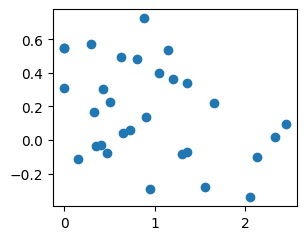

SignificanceResult(statistic=-0.35347807365179845, pvalue=0.05534080393805999)


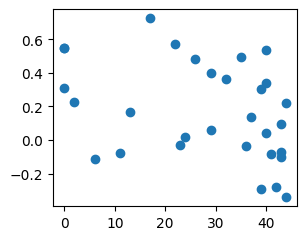

SignificanceResult(statistic=-0.43498667994240475, pvalue=0.016293507464527752)


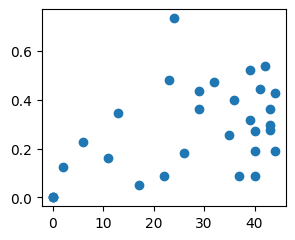

SignificanceResult(statistic=0.4447668040895589, pvalue=0.013792194492852424)


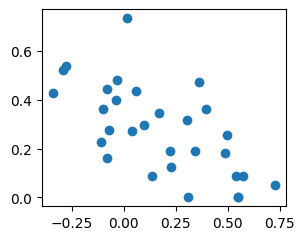

SignificanceResult(statistic=-0.6514578878228234, pvalue=9.647558635338533e-05)


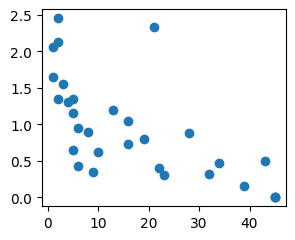

SignificanceResult(statistic=-0.796656013452659, pvalue=1.3898572470591493e-07)


In [5]:
add_eeg_dir = f'../../../datasets/2306/2306_elan/preprocessing/11_add_Transcrip_to_IM'
subject_ID_csv_list = sorted(os.listdir(f'{add_eeg_dir}'))
subject_ID_list = [i.removesuffix('.csv') for i in subject_ID_csv_list]

# from "Threshold_setting_reason.ipynb" in the same level directori
threshold_list_df = pd.read_csv(f'../../project-ACII2024/paper_result/Threshold_search_20240210230435/threshold_list.csv', header=0)

recall_change_level_each_bin_df = pd.DataFrame()
recall_change_level_each_bin_df2 = pd.DataFrame()
del_dim_num_list_df = pd.DataFrame()
for subject_ID in subject_ID_list:
    all_open_close_pxx_df = pd.read_csv(f'../../project-ACII2024/rest_and_btw_log/1701767293/resting_session/all_open_close_pxx_df.csv', header=0)
    all_recall_pxx_df = pd.read_csv(f'../../project-ACII2024/rest_and_btw_log/1703138526/recall_session/all_recall_pxx_df.csv', header=0)
    
    all_open_close_pxx_df_2306M2002 = pd.read_csv(f'../../project-ACII2024/rest_and_btw_log/1706949098/resting_session/all_open_close_pxx_df_2306M2002.csv', header=0)
    all_open_close_pxx_df = pd.concat([all_open_close_pxx_df,all_open_close_pxx_df_2306M2002], axis=0).reset_index(drop=True)
    
    tmp_QUE = 'subject_ID == ' + '\"' + subject_ID + '\"'
                                            
    subject_open_df = all_open_close_pxx_df[all_open_close_pxx_df["ex_ID"].str.contains("open")]           
    subject_open_df = subject_open_df.query(tmp_QUE).loc[:, '2':'46'].reset_index(drop=True)
    subject_open_close_df = subject_open_df.div(subject_open_df.sum(axis=1), axis=0)
    
    subject_recall_df = all_recall_pxx_df.query(tmp_QUE).loc[:, '2':'46'].reset_index(drop=True)
    
    recall_change_level_each_bin = subject_recall_df.mean(axis=0) / subject_open_close_df.mean(axis=0)
    recall_change_level_each_bin_df = pd.concat([recall_change_level_each_bin_df, pd.DataFrame(recall_change_level_each_bin).T], axis=0).reset_index(drop=True)
    
    tmp = pd.concat([subject_recall_df.mean(axis=0) , subject_open_close_df.mean(axis=0)], axis=0)
    recall_change_level_each_bin_df2 = pd.concat([recall_change_level_each_bin_df2, pd.DataFrame(tmp).T], axis=0).reset_index(drop=True)
    
    #print(subject_ID, np.round(subject_recall_df.mean(axis=0).sum(), decimals=2), np.round(subject_open_close_df.mean(axis=0).sum(), decimals=2))
    
    del_column_num_list = []
    j = 0
    for power_of_bin in recall_change_level_each_bin:
        
        valid_value = threshold_list_df.query(tmp_QUE)['Corr_max_threshold'].iloc[-1]
        
        if power_of_bin < valid_value:
            del_column_num_list.append(j)
            if len(del_column_num_list) == 45:
                del_column_num_list = np.delete(np.arange(0,45,1), int(recall_change_level_each_bin.reset_index(drop=True).idxmax()))
        else:
            pass
       
        j += 1
    
    del_dim_num = len(del_column_num_list)
        
    tmp_df = pd.DataFrame(data=[{
                                'subject_ID': subject_ID, 'Corr_max_threshold': valid_value, 'del_dim_num': del_dim_num,
                                'recall_change_level_each_bin_ave': recall_change_level_each_bin.mean(),
                                'recall_change_level_delta': recall_change_level_each_bin[np.arange(0,3,1)].mean(),
                                'recall_change_level_theta': recall_change_level_each_bin[np.arange(3,6,1)].mean(),
                                'recall_change_level_alpha': recall_change_level_each_bin[np.arange(7,12,1)].mean(),
                                'recall_change_level_beta': recall_change_level_each_bin[np.arange(12,29,1)].mean(),
                                'recall_change_level_gamma': recall_change_level_each_bin[np.arange(29,45,1)].mean(),
                                }])
    
    #sect_feat_bin = np.arange(0,3,1)   ##### delta     frequency corresponded to IM00-IM02 1 < w < 4
    #sect_feat_bin = np.arange(3,6,1)   ##### theta     frequency corresponded to IM03-IM05 4 < w < 7
    #sect_feat_bin = np.arange(7,12,1)   ##### alpha    frequency corresponded to IM07-IM11 8 < w < 13
    #sect_feat_bin = np.arange(12,29,1) ##### beta      frequency corresponded to IM12-IM28 13 < w < 30
    #sect_feat_bin = np.arange(29,45,1) ##### gamma     frequency corresponded to IM29-IM44 30 < w < 45
    
    del_dim_num_list_df = pd.concat([del_dim_num_list_df, tmp_df], axis=0).reset_index(drop=True)

del_dim_num_list_df.to_csv(f'../../project-ACII2024/paper_result/del_dim_num_list_df.csv', index=False)

cm = 1/2.54  # centimeters in inches

plt.figure(figsize=(8*cm, 6.5*cm))
# 最適な閾値（最も相関係数が高い閾値）において削除する次元が多い人ほど，元々の性能が低い　pvalue=0.055
plt.scatter(threshold_list_df['Corr_max_threshold'], threshold_list_df['Rs_NONE'])
plt.show()
print(spearmanr(threshold_list_df['Corr_max_threshold'], threshold_list_df['Rs_NONE']))

plt.figure(figsize=(8*cm, 6.5*cm))
# 最適な閾値（最も相関係数が高い閾値）での"実際の最適な閾値での削除次元数と，元々の性能の相関　pvalue=0.016
plt.scatter(del_dim_num_list_df['del_dim_num'], threshold_list_df['Rs_NONE'])
plt.show()
print(spearmanr(del_dim_num_list_df['del_dim_num'], threshold_list_df['Rs_NONE']))

plt.figure(figsize=(8*cm, 6.5*cm))
# "実際の最適な閾値での削除次元数"と，性能改善の相関　pvalue=0.013
plt.scatter(del_dim_num_list_df['del_dim_num'], threshold_list_df['Corr_max_optimized'] - threshold_list_df['Rs_NONE'])
plt.show()
print(spearmanr(del_dim_num_list_df['del_dim_num'], threshold_list_df['Corr_max_optimized'] - threshold_list_df['Rs_NONE']))


plt.figure(figsize=(8*cm, 6.5*cm))
# 元々の性能（相関係数）と性能改善は強い負相関 P < 0.001
plt.scatter(threshold_list_df['Rs_NONE'], threshold_list_df['Corr_max_optimized'] - threshold_list_df['Rs_NONE'])
plt.show()
print(spearmanr(threshold_list_df['Rs_NONE'], threshold_list_df['Corr_max_optimized'] - threshold_list_df['Rs_NONE']))

plt.figure(figsize=(8*cm, 6.5*cm))

plt.scatter(45-del_dim_num_list_df['del_dim_num'], threshold_list_df['Corr_max_threshold'])
plt.show()
print(spearmanr(45-del_dim_num_list_df['del_dim_num'], threshold_list_df['Corr_max_threshold']))


# # 元々の性能（相関係数）と平均相対変化度は正相関方向だが有意差なし P < 0.13
# plt.figure(figsize=(8.5*cm, 6*cm))
# plt.scatter(del_dim_num_list_df['recall_change_level_each_bin_ave'], threshold_list_df['Rs_NONE'])
# plt.show()
# print(spearmanr(del_dim_num_list_df['recall_change_level_each_bin_ave'], threshold_list_df['Rs_NONE']))
# del_dim_num_list_df


Corr between rec/res ration and Optimized number

In [ ]:
print('AVE')
plt.figure(figsize=(8.5*cm, 6*cm))
# "ラベルを使用することで求められる最適な閾値での削除次元数"をラベル無しでどのように求めるか
# "実際の最適な閾値での削除次元数"と平均相対変化度は有意に負相関 pvalue=0.011
plt.scatter(del_dim_num_list_df['recall_change_level_each_bin_ave'], del_dim_num_list_df['del_dim_num'])
plt.show()
print(spearmanr(del_dim_num_list_df['recall_change_level_each_bin_ave'], del_dim_num_list_df['del_dim_num']))
print('"実際の最適な閾値での削除次元数"と平均相対変化度は有意に負相関 pvalue=0.011')

plt.figure(figsize=(8.5*cm, 6*cm))
print()
print('delta')
plt.scatter(del_dim_num_list_df['recall_change_level_delta'], del_dim_num_list_df['del_dim_num'])
plt.show()
print(spearmanr(del_dim_num_list_df['recall_change_level_delta'], del_dim_num_list_df['del_dim_num']))

plt.figure(figsize=(8.5*cm, 6*cm))
print()
print('theta')
plt.scatter(del_dim_num_list_df['recall_change_level_theta'], del_dim_num_list_df['del_dim_num'])
plt.show()
print(spearmanr(del_dim_num_list_df['recall_change_level_theta'], del_dim_num_list_df['del_dim_num']))

plt.figure(figsize=(8.5*cm, 6*cm))
print()
print('alpha')
plt.scatter(del_dim_num_list_df['recall_change_level_alpha'], del_dim_num_list_df['del_dim_num'])
plt.show()
print(spearmanr(del_dim_num_list_df['recall_change_level_alpha'], del_dim_num_list_df['del_dim_num']))

plt.figure(figsize=(8.5*cm, 6*cm))
print()
print('beta')
plt.scatter(del_dim_num_list_df['recall_change_level_beta'], del_dim_num_list_df['del_dim_num'])
plt.show()
print(spearmanr(del_dim_num_list_df['recall_change_level_beta'], del_dim_num_list_df['del_dim_num']))

plt.figure(figsize=(8.5*cm, 6*cm))
print()
print('gamma')
plt.scatter(del_dim_num_list_df['recall_change_level_gamma'], del_dim_num_list_df['del_dim_num'])
plt.show()
print(spearmanr(np.log(del_dim_num_list_df['recall_change_level_gamma']), del_dim_num_list_df['del_dim_num']))



Prediction of del_dim_num

X_train.shape (29, 3) y_train.shape (29,) X_test.shape (1, 3) y_test.shape (1,)


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.01}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 0.001, 'hidden_layer_sizes': (5,), 'learning_rate_init': 1}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.1}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 0.1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 1}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 0.01, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.1}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 1}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 0.1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.01}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.01}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 1}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 0.1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.1}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 0.01, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.1}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.1}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.1}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.1}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.01}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 1}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.01}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.01}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.01}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.1}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 0.01, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.01}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 0.01, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.01}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.1}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 0.01, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.1}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 0.001, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.1}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 0.1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.1}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 0.1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.1}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 0.001, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.1}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 0.1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.1}


/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/katada/anaconda3/envs/tfbert/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  war

{'alpha': 0.1, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.01}
PearsonRResult(statistic=0.5330312685509877, pvalue=0.0024228929503107995)


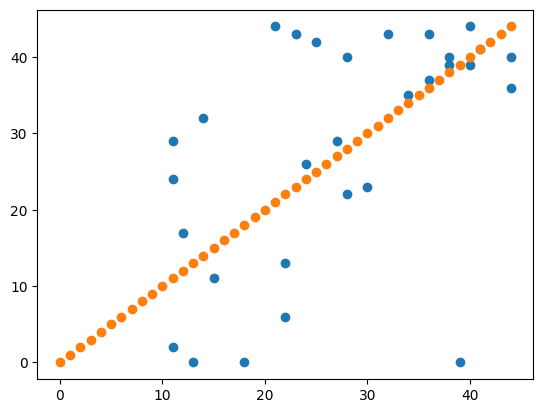

,subject_ID,Corr_max_threshold,del_dim_num,recall_change_level_each_bin_ave,recall_change_level_delta,recall_change_level_theta,recall_change_level_alpha,recall_change_level_beta,recall_change_level_gamma,pred_del_dim
0,2306F2003,2.325,24,2.319387,1.044334,1.265100,0.935886,2.179670,3.394309,11.0
1,2306F2005,2.050,44,0.821283,0.922148,1.870828,1.301637,0.678440,0.610025,21.0
2,2306F2006,0.500,2,1.623282,0.747768,2.145841,2.165773,1.505678,1.660907,11.0
3,2306F3002,0.475,11,0.743885,1.299350,0.626280,0.470636,0.770947,0.737504,15.0
4,2306F3004,1.650,44,0.355561,1.630317,0.789674,0.234768,0.257265,0.174435,40.0
5,2306F4002,0.000,0,1.190519,0.901264,3.053408,0.741721,0.759627,1.467983,13.0
6,2306F4003,0.725,29,0.667164,1.287488,0.815912,0.670063,0.571056,0.648106,27.0
7,2306F4004,0.000,0,0.408686,1.651354,1.512990,0.294239,0.211016,0.187346,39.0
8,2306F5003,0.000,0,1.334097,1.359964,1.495929,0.394060,0.932537,2.054721,18.0
9,2306F5004,0.900,37,0.473791,1.582836,1.137908,0.442993,0.375871,0.211889,36.0


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.exceptions import ConvergenceWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
warnings.simplefilter('ignore', ConvergenceWarning)

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

#tmp_df = del_dim_num_list_df.loc[:, 'recall_change_level_beta':'recall_change_level_gamma']
tmp_df = del_dim_num_list_df.reindex(columns=['recall_change_level_each_bin_ave', 'recall_change_level_beta', 'recall_change_level_gamma'])

pred_df = del_dim_num_list_df.reindex(columns=['subject_ID', 'del_dim_num'])
pred_df = pd.concat([pred_df, tmp_df], axis=1)
#pred_df['age'] = del_dim_num_list_df['subject_ID'].str[-4:-2].astype(int) / 100
#pred_df['sex'] = np.concatenate([np.ones(16), np.zeros(14)])

pred_del_dim_list = []
y = []
for subject_ID in subject_ID_list:

    train_QUE = 'subject_ID != ' + '\"' + subject_ID + '\"' 
    test_QUE = 'subject_ID == ' + '\"' + subject_ID + '\"'
                       
    train_df = pred_df.query(train_QUE)
    test_df = pred_df.query(test_QUE)
    
    X_train = train_df.iloc[:, 2:].values
    y_train = train_df['del_dim_num'].values
    X_test = test_df.iloc[:, 2:].values
    y_test = test_df['del_dim_num'].values
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    if subject_ID == subject_ID_list[0]:
        print('X_train.shape', np.shape(X_train), 'y_train.shape', np.shape(y_train), 'X_test.shape', np.shape(X_test), 'y_test.shape', np.shape(y_test))
    
    #regr =  MLPRegressor(hidden_layer_sizes=(5,), activation='relu', solver='adam', alpha=0.01, learning_rate_init=1, random_state=0, early_stopping=True, validation_fraction=0.1)
    
    #regr = GridSearchCV(SVR(kernel='rbf', max_iter=1000), cv=3, param_grid=tuned_parameters, scoring='neg_mean_squared_error', n_jobs=-1)
    
    tuned_parameters = [{'hidden_layer_sizes':[(5,)], 'alpha': [0.001, 0.01, 0.1, 1], 'learning_rate_init':[0.001, 0.01, 0.1, 1]}]
    regr = GridSearchCV(MLPRegressor(activation='relu', solver='adam', random_state=0, early_stopping=True, validation_fraction=0.1, max_iter=1000),
                        cv=3, param_grid=tuned_parameters, scoring='neg_mean_absolute_error', n_jobs=-1)
    
    # hidden_layer_sizes=(5,)
    
    regr.fit(X_train, y_train)
    print(regr.best_params_)
    best = regr.best_estimator_
    pred_del_dim = np.ceil(best.predict(X_test))
    
    # tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],'epsilon': np.arange(0,1.1,0.5)}]
    # regr = GridSearchCV(SVR(kernel='rbf', max_iter=1000), cv=3, param_grid=tuned_parameters, scoring='neg_mean_squared_error', n_jobs=-1)
    # regr.fit(X_train, y_train)
    # #print(regr.best_params_)
    # best = regr.best_estimator_
    # pred_del_dim = best.predict(X_test)
        
    pred_del_dim_list.append(pred_del_dim[-1])
    y.append(y_test)
    
pred_del_dim_list = np.where(np.array(pred_del_dim_list) < 0, 0, pred_del_dim_list)
pred_del_dim_list = np.where(np.array(pred_del_dim_list) > 44,44, pred_del_dim_list)

#pred_del_dim_list_a = pred_del_dim_list
#pred_del_dim_list_b = pred_del_dim_list
#pred_del_dim_list_c = pred_del_dim_list
    
print(pearsonr(pred_del_dim_list, np.ravel(y)))
del_dim_num_list_df['pred_del_dim'] = pred_del_dim_list
plt.scatter(pred_del_dim_list, np.ravel(y))
plt.scatter(np.arange(0,45,1), np.arange(0,45,1))
plt.show()
del_dim_num_list_df

### Late fusion

In [ ]:
timestr = timestr
combination_list = []
for n in range(1,len(modality_list)+1):
	for comb in itertools.combinations(modality_list, n):
	    combination_list.append(list(comb))
late_fusion_list = [s for s in combination_list] # if not s in [[modality_list[0]], [modality_list[1]], [modality_list[2]]]] # use if there are modalities you don't want to fuse

dependency = dep_list[-1]
task_name = task_list[-1]
eval_name_list = eval_list[-1]
label_name = label_name_list[-1]
fusion_method = 'ensemble'
ml_mod = 'ensemble_model'

for modal_comb in late_fusion_list:
    if len(modal_comb) == 1: # omit unimodal
        continue
    for subject_ID in subject_ID_list:
        for rep_exp_num in range(rep_exp):
            rep_exp_num += 1
            modal_count_i = 0
            
            for modal in modal_comb:
                if modal == 'IM':
                    modal_dir = 'bin_sect_thres_v2'
                else:
                    modal_dir = '[\''  + modal + '\']'
                proba_csv_path = f'../ML_results/dummy/reg_pred/{timestr}/{subject_ID}/{label_name}/{modal_dir}/SVM/uni/rep_exp_num_{rep_exp_num}.csv'
                tmp_proba_df = pd.read_csv(f'{proba_csv_path}')

                tmp_pred_ar = tmp_proba_df['y_pred'].values
                
                if modal_count_i == 0:
                    y_pred_ar = tmp_pred_ar
                    modal_count_i += 1
                else:
                    y_pred_ar = y_pred_ar + tmp_pred_ar # adding each modal prediction value
                    modal_count_i += 1
                    
            info_dict = {'subject_ID': subject_ID, 'dependency': dependency, 'task_name': task_name,
                        'label_name': label_name, 'modal_comb': modal_comb, 'ml_mod': ml_mod,
                        'fusion_method': fusion_method, 'rep_exp_num': rep_exp_num, 'f1_setting': None,
                        'timestr': timestr, 'elapsed': None,
                        'valid_target': 'bin_sect_thres'
                        }

            y_pred = y_pred_ar / len(modal_comb) # averaging the prediction value
            y_true = tmp_proba_df['y_true'].values
            
            print('rep_exp_num:', rep_exp_num, ', modal_count:', modal_count_i, modal_comb, 'y_pred', np.round(y_pred, decimals=1), 'y_true', y_true)
            
            save_pred_and_prob(task_name, None, y_pred, y_true, info_dict)
            
            mae = mean_absolute_error(y_true, y_pred)
            if len(np.unique(y_true)) == 1:
                r2, rp, rq = np.nan, np.nan, np.nan
            else:
                r2 = r2_score(y_true, y_pred)
                rp = pearsonr(y_true, y_pred)[0]
                rs = spearmanr(y_true, y_pred)[0]
                
            reg_evalist = [mae, r2, rp, rs]
            print('test_MAE:', np.round(mae, decimals=3), f'test_R2:', np.round(r2, decimals=3), end=' ')
            print('test_Rp:', np.round(rp, decimals=3), f'test_Rs:', np.round(rs, decimals=3))
            print()
            
            save_cls_or_reg(reg_evalist, eval_name_list, info_dict, rep_exp)